In [84]:
import numpy as np
import pandas as pd
import sklearn

print(sklearn.__version__)

0.23.1


## Voting Ensemble

Voting can be implemented by VotingRegressor and Voting Classifier provided by Sklearn. They accept a list of base models as a parameter 'estimators', which is a list of tuples with the name of a model and the model instance. For classification, 'voting' argument can also be defined to specify which voting type(hard or soft) will be used.

```
models = [ ('lr', LogisticRegression()), ('SVM', SVC()) ]
ensemble = VotingClassifier(estimators=models)

models = [ ('tree', DecisionTree()), ('linear_regression', LinearRegression()) ]
ensemble = VotingRegressor(estimators=models)
```


## Hard Vote

In [85]:
from numpy import mean
from numpy import std

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt


create synthetic data by sklearn


In [86]:

def get_data():
    X, y = make_classification(n_samples=2000, n_features=20, n_informative=15, n_redundant=5, random_state=2)
    return X, y


In [87]:
X, y = get_data()

X.shape, y.shape


((2000, 20), (2000,))


We use KNN with different paramters as our base models.


In [88]:
def get_ensemble():
    models = []
    
    for n in [1, 3, 5, 7, 9]:
        knn_i = KNeighborsClassifier(n_neighbors=n)
        models.append(('knn_' + str(n), knn_i))

    ensemble_model = VotingClassifier(estimators=models, voting='hard')
    
    return ensemble_model
    
def get_compared_models():
    models = []
    for n in [1, 3, 5, 7, 9]:
        knn_i = KNeighborsClassifier(n_neighbors=n)
        models.append(('knn_' + str(n), knn_i))
    models.append(('ensemble', get_ensemble()))
    return models
        
    

evaluate model by cross-validation

In [89]:
def evaluate(model, X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


train the models


In [90]:
models = get_compared_models()
results, names = [], []
for name, model in models:
    scores = evaluate(model, X, y)
    results.append(scores)
    names.append(name)
    print(name, mean(scores))


knn_1 0.8985
knn_3 0.9244999999999999
knn_5 0.93
knn_7 0.9330000000000002
knn_9 0.9279999999999999
ensemble 0.9355


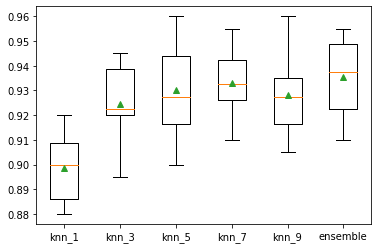

In [91]:
plt.boxplot(results, labels=names, showmeans=True)

plt.show()


## Regression

In [92]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor


In [93]:

X_r, y_r = make_regression(n_samples=2000, n_features=20, n_informative=15, noise=0.1, random_state=42)

X_r.shape, y_r.shape


((2000, 20), (2000,))

we will use decision tree with different depths as our base models


In [94]:

def get_regression_ensemble():
    models = []
    
    for n in range(1, 6):
        dt_i = DecisionTreeRegressor(max_depth=n)
        models.append(('tree_' + str(n), dt_i))

    ensemble_model = VotingRegressor(estimators=models)
    
    return ensemble_model
  
def get_compared_regression_models():
    models = []
    
    for n in range(1, 6):
        dt_i = DecisionTreeRegressor(max_depth=n)
        models.append(('tree_' + str(n), dt_i))

    models.append(('ensemble', get_regression_ensemble()))

    return models
    

evaluate the models


In [95]:
def evaluate_regression(model, X, y):
    cv = StratifiedKFold(n_splits=10)

    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    
    return scores


train models


In [96]:
models = get_compared_regression_models()

results, names = [], []
for name, model in models:
    scores = evaluate_regression(model, X, y)
    results.append(scores)
    names.append(name)
    print(name, mean(scores))


tree_1 -0.21406525446978986
tree_2 -0.17147639005515655
tree_3 -0.17239744615405236
tree_4 -0.16389575818137037
tree_5 -0.16042964994271697
ensemble -0.15730821526468367


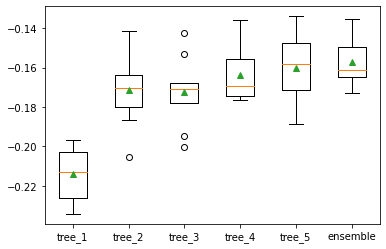

In [97]:
plt.boxplot(results, labels=names, showmeans=True)

plt.show()


## AdaBoost


In [ ]:
## Loss Functions
def get_weighted_pmk(y, weights):
    ks = np.unique(y)
    weighted_pmk = [sum(weights[y == k]) for k in ks]      
    return(np.array(weighted_pmk)/sum(weights))

def gini_index(y, weights):
    weighted_pmk = get_weighted_pmk(y, weights)
    return np.sum( weighted_pmk*(1-weighted_pmk) )

def cross_entropy(y, weights):
    weighted_pmk = get_weighted_pmk(y, weights)    
    return -np.sum(weighted_pmk*np.log2(weighted_pmk))

def split_loss(child1, child2, weights1, weights2, loss = cross_entropy):
    return (len(child1)*loss(child1, weights1) + len(child2)*loss(child2, weights2))/(len(child1) + len(child2))
 

class AdaBoost:    
    def fit(self, X_train, y_train, T, stub_depth = 1):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.T = T
        self.stub_depth = stub_depth
        
        ## Instantiate stuff
        self.weights = np.repeat(1/self.N, self.N)
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        
        for t in range(self.T):
            ## Calculate stuff
            self.T_t = DecisionTreeClassifier()
            self.T_t.fit(self.X_train, self.y_train, self.weights, max_depth = self.stub_depth)
            self.yhat_t = self.T_t.predict(self.X_train)
            
            # Weighted error rate of the M predictor
            self.epsilon_t = sum(self.weights*(self.yhat_t != self.y_train))/sum(self.weights)
            # predictor weight
            self.alpha_t = np.log( (1-self.epsilon_t)/self.epsilon_t )
            # update sampe weight: if classify correctly, w; else w*exp(\alpha)
            self.weights = np.array([w*(1-self.epsilon_t)/self.epsilon_t if self.yhat_t[i] != self.y_train[i]
                                    else w for i, w in enumerate(self.weights)])
            # TODO: normalize w to ensure the sum of w is 1

            ## Append stuff
            self.trees.append(self.T_t)
            self.alphas.append(self.alpha_t)
            self.yhats[:,t] = self.yhat_t 
            
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))
        
    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree = tree.predict(X_test)
            yhats += yhats_tree*self.alphas[t]
        return np.sign(yhats)


In [227]:


data = {
    "chest_pain": ['Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes'],
    "blocked_arteries": ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes'],
    "weight": [205, 180, 210, 167, 156, 125, 168, 172],
    "heart_disease": ['Yes', 'Yes', 'Yes', 'Yes','No','No', 'No', 'No']
}

df = pd.DataFrame(data)

df = df.replace(['Yes', 'No'], [1, 0])

df['weights'] = 1/8

df


,chest_pain,blocked_arteries,weight,heart_disease,weights
0,1,1,205,1,0.125
1,0,1,180,1,0.125
2,1,0,210,1,0.125
3,1,1,167,1,0.125
4,0,1,156,0,0.125
5,0,1,125,0,0.125
6,1,0,168,0,0.125
7,1,1,172,0,0.125


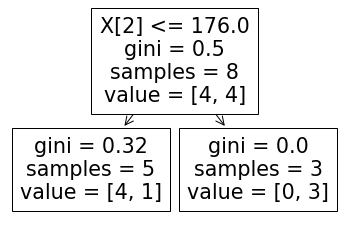

In [228]:
from sklearn import tree

X = df.drop(['heart_disease', 'weights'], axis=1)
y = df['heart_disease']

clf = tree.DecisionTreeClassifier(max_depth=1) 
clf = clf.fit(X, y)

tree.plot_tree(clf.fit(X, y))
plt.show()


In [229]:
def cal_alpha(error):
    return 0.5*np.log((1 - error)/error)


In [230]:
alpha_1 = cal_alpha(1/8)

correct_samples = df[clf.predict(X) == y]
df.loc[clf.predict(X) == y, 'weights'] = correct_samples['weights'] * np.exp(-alpha_1)

misclassified_samples = df[clf.predict(X) != y]
df.loc[clf.predict(X) != y, 'weights'] = misclassified_samples['weights'] * np.exp(alpha_1)

print(alpha_1)

df


0.9729550745276566


,chest_pain,blocked_arteries,weight,heart_disease,weights
0,1,1,205,1,0.047246
1,0,1,180,1,0.047246
2,1,0,210,1,0.047246
3,1,1,167,1,0.330719
4,0,1,156,0,0.047246
5,0,1,125,0,0.047246
6,1,0,168,0,0.047246
7,1,1,172,0,0.047246


In [231]:
df['weights']/df['weights'].sum()


0    0.071429
1    0.071429
2    0.071429
3    0.500000
4    0.071429
5    0.071429
6    0.071429
7    0.071429
Name: weights, dtype: float64